<a href="https://colab.research.google.com/github/vorst4/TUE_5LSM0_g6/blob/master/TUE_5LSM0_g6_dennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ------------------------------ Import modules ------------------------------ #

import os
import sys
import json
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from glob import glob
from datetime import datetime
from PIL import Image
from google.colab import drive

try:
  import rdp
except:
  !pip install rdp
  import rdp

# ---------------------- Import modules from Git source ---------------------- #

# efficient net
try:
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
except:
  print('\nInstalling efficient-net...')
  !pip install -e git+https://github.com/lukemelas/EfficientNet-PyTorch#egg=EfficientNet
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
  print('Done')

# # shap
# try:
#   import shap
# except:
#   print('\nInstalling shap...')
#   !pip install shap
#   import shap
#   print('Done')


# ----------------------------- Initialize Colab ----------------------------- #
#
# NOTE: all console commands (the ones that start with !) cannot be run from a 
# .py script. Usually this is possible using the command 'os.system('...')'.
# However, in Colab, it is for some reason not possible to obtain the console
# output of the command that is run. This makes it impossible to notify the user
# if an error occurs. All the commands therefore need to be run in the main
# .ipynb script (which is this script).
#


# check if GPU is enabled
if torch.cuda.is_available() == False:
  print('\nWARNING: GPU not enabled. Goto runtime -> change runtime type')


# mount Google Drive (if needed)
if not os.path.exists('drive'):
  print('\nMounting Google Drive...')
  drive.mount('/content/drive')
  print('Done')


# setup Git (if needed)
if not os.path.exists('TUE_5LSM0_g6'):
  print('\nSetting up git...')
  print('...Loading github.json from Google Drive')
  with open('/content/drive/My Drive/github.json', 'r') as json_file:
    gitconfig = json.load(json_file)
  print('...Cloning git repo')
  url = 'https://'+gitconfig["username"]+':'+gitconfig["key"]+\
        '@github.com/vorst4/TUE_5LSM0_g6.git'
  !git clone {url}
  print('...Setting username and email')
  !git -C TUE_5LSM0_g6 config user.name {gitconfig["username"]}
  !git -C TUE_5LSM0_g6 config user.email {gitconfig["email"]}
  print('Done')


# remove default sample_data folder (if needed)
if os.path.exists('sample_data'):
  print('\nRemoving sample_data...')
  os.system('rm -r sample_data')
  print('Done')


# copy and unzip data from Google Drive (if needed)
if not os.path.exists('ISIC_2019_Test_Input'):
  print('\nGetting data...')
  print('...Copying data.zip from Google Drive to workfolder')
  !cp 'drive/My Drive/5LSM0-final-assignment/data.zip' .
  print('...Unpacking data.zip')
  !unzip -q data.zip
  print('...Removing data.zip')
  !rm data.zip
  print('Done\n')


# ----------------------------- Import Functions ----------------------------- #
#
# NOTE: The modules need to be forcibly reloaded because Colab does not do this
# by default, even if the module has changed.
#

# append git dir to systems paths
sys.path.append('TUE_5LSM0_g6')

# dataloaders
import dataloaders
importlib.reload(dataloaders)
dataloaders = dataloaders.dataloaders

# train & accuracy
import train
importlib.reload(train)
accuracy = train.accuracy
train = train.train

# resnet18
import resnet18
importlib.reload(resnet18)
resnet18 = resnet18.resnet18

# backup
import backup
importlib.reload(backup)
backup = backup.backup

# restore
import restore
importlib.reload(restore)
restore = restore.restore

# isic_challenge_scoring (module, that does not change)
import isic_challenge_scoring
from isic_challenge_scoring.classification import ClassificationScore


# --------------------------------- Constants -------------------------------- #

N_classes = 9

# --------------------------------- Settings --------------------------------- #

# settings object
S = type('settings', (), {})()

# use gpu/cpu
if torch.cuda.is_available():
  S.device = torch.device('cuda')
else:
  S.device = torch.device('cpu')

# image size (squared)
S.modelname = 'efficientnet-b0'
S.img_size = EfficientNet.get_image_size(S.modelname)

# set variable type
S.dtype = torch.float32

# when to print
S.print_every = 100

# number of epochs to run
S.epochs = 50

# batch size, increase this until the RAM is full
S.batch_size = 32

# percentage of original train set that is to be used for validation
S.val_ratio = 99

# restore last backup of model?
S.load_backup = True

# Create backup each epoch?
S.backup_each_epoch = False

# Create backup if training is finished?
S.backup_on_finish = False


# ----------------------------------- Main ----------------------------------- #

# create data loader objects for train, validation and test set.
dl_train, dl_val, dl_test = dataloaders(batch_size=S.batch_size,
                                        val_ratio = S.val_ratio,
                                        img_size = S.img_size)

# learning rate (with decay)
# todo: make a script that runs the model with different rates
learning_rate = 1e-3
decayRate = 0.9

# model
# model = resnet18(S.img_size)

# load pretrained efficientnet model (b0 is the smallest model). Note that img
# size must be 224 for model b0
if S.img_size == EfficientNet.get_image_size(S.modelname):
  model = EfficientNet.from_pretrained(S.modelname, N_classes)
  # model = EfficientNet.from_name(S.modelname, N_classes)


# load non-pretrained model (compare these two later on)
# model = EfficientNet.from_pretrained('efficientnet-b0')

# print layer sizes
# model.print_layer_sizes()


# load backup
if S.load_backup:
  model = restore(model, S.modelname)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
lr_exp = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# train
# train(model, optimizer, dl_train, dl_val, lr_exp, S)
x, y_true, scores = train(model, optimizer, dl_train, dl_val, lr_exp, S)
scores = scores[:, :9] # only take the first 9 out of 1000 classes

# visualize results
# model.visualize()

# save obtained model (not needed if it is already saved after each epoch)
if S.backup_on_finish and not S.backup_each_epoch:
  backup(model, S.modelname)

# # get accuracy best model
# best_model = model
# accuracy(dl_test, best_model)

# create csv file of test data
# make_cvs(model)


# ----------------------------------- End ------------------------------------ #



Loaded pretrained weights for efficientnet-b0

Restored model

Number of iterations per epoch:  791


In [28]:
# ------------------------- GIT Pull, Commit & Push -------------------------- #

def git():

  if not input('\nPull? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 pull

  commit_msg = '\''+input('\nEnter commit message: ')+'\''

  if not input('\nCommit? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 add .
  !git -C /content/TUE_5LSM0_g6 commit -m {commit_msg}

  if not input('\nPush? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 push

git()

# ----------------------------------- End ------------------------------------ #


KeyboardInterrupt: ignored

In [63]:

import sklearn
import pandas as pd
import isic_challenge_scoring
importlib.reload(isic_challenge_scoring)


tmp1 = np.exp(scores.detach())
tmp2 = (tmp1.sum(1)).view(tmp1.size()[0], 1)
p_scores = tmp1/tmp2
# p_scores = scores.detach()


# make sure that every label occurs at least once in y_true. This is done by 
# setting sample <i> to class <i> (basically the first 9 samples to each class)
for i in range(N_classes):
  # set y_true
  y_true[i] = i
  # also change p_scores such that the data isn't crap
  tmp, idx = p_scores[i, :].max(0)
  p_scores[i, idx] = p_scores[i, i]
  p_scores[i, i] = tmp

y_true[0] = 0
y_true[1] = 1
y_true[2] = 2
y_true[3] = 3
y_true[4] = 4
y_true[5] = 5
y_true[6] = 6
y_true[7] = 7
y_true[8] = 8

y_true2 = np.zeros((S.batch_size, N_classes))
for i in range(N_classes):
  y_true2[y_true==i, i] = 1

print('\n------------------------------------')
print('x.size = \t', list(x.size()) )
print('y_true = \t', list(y_true.shape))
print('y_true2 = \t', list(y_true2.shape))
print('scores = \t', list(scores.shape))
print('n_labels = \t', len(np.unique(y_true)))
print('labels = \t', np.unique(y_true))
print('p_scores = \t', list(p_scores.shape))
print('------------------------------------\n')





------------------------------------
x.size = 	 [32, 3, 224, 224]
y_true = 	 [32]
y_true2 = 	 [32, 9]
scores = 	 [32, 9]
n_labels = 	 9
labels = 	 [0 1 2 3 4 5 6 7 8]
p_scores = 	 [32, 9]
------------------------------------



In [64]:

score = sklearn.metrics.roc_auc_score(y_true2, p_scores)

print(score)


1.0


[0.         0.         0.         0.         0.03448276 0.06896552
 0.10344828 0.13793103 0.17241379 0.20689655 0.24137931 0.27586207
 0.31034483 0.34482759 0.37931034 0.4137931  0.44827586 0.48275862
 0.51724138 0.55172414 0.5862069  0.62068966 0.65517241 0.68965517
 0.72413793 0.75862069 0.79310345 0.82758621 0.86206897 0.89655172
 0.93103448 0.96551724 1.        ]
[0.         0.33333333 0.66666667 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
[1.9999940e+00 9.9999410e-01 9.9995691e-01 9.9961221e-01 5.4744203e-05
 8.0528690e-07 4.3886718e-07 1.8771581e-07 1.2745276e-07 8.9393268e-08
 8.0846831e-08 9.4642827e-09 6.1375585e-09 4.9608890e-09 3.9989585e-09
 8.9398972e-10 5.0894799e-10 2.7331645e-10 2.2659159e-10 1.8823858e-10
 9.9658851e-11 9

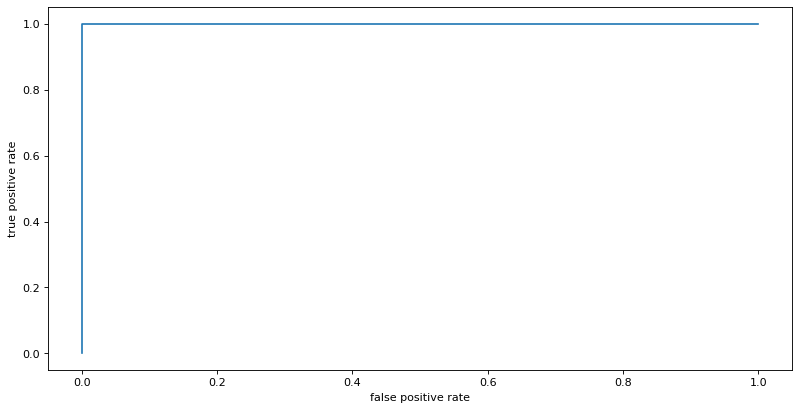

In [66]:

bool_use_weights = False

# determine number of images per label
N_imgs = np.zeros(N_classes)
for i in range(N_classes):
  N_imgs[i] = (y_true == i).sum()

# determine weight per label, depending on the (inverse) amount of images
w_lbl = 1/N_imgs
w_lbl = w_lbl / sum(w_lbl) # normalize it

# determine weight per image
if bool_use_weights:
  w = y_true2 * w_lbl
  w = w.sum(1) # only 1 non-zero element per row
else:
  w = np.ones(S.batch_size)


# determine roc_curve
fpr, tpr, thr = sklearn.metrics.roc_curve(y_true2[:, 0], 
                                          p_scores[:, 0], 
                                          sample_weight=w,
                                          drop_intermediate=False)

print(fpr)
print(tpr)
print(thr)


import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(fpr,tpr)
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()


In [9]:

# w = np.zeros(N_classes)
# for i in range(N_classes):
#   w[i] = 1/(y_true==i).sum()

w = np.zeros(S.batch_size)
for i in range(S.batch_size):
  w[i] = 1/(y_true==i).sum()


print(len(w))
  

# print(tmp.shape)
# p_scores = np.ones(tmp.shape)
# for i in range(p_scores.shape[1]):
#   p_scores[:, i] = tmp[:, i] / np.sum(tmp[i, :])

# print(w)


yt = pd.DataFrame(y_true2)
p = pd.DataFrame(p_scores)
weight = pd.DataFrame()
weight.score_weight = pd.DataFrame(w)
# weight.score_weight = None

scores = ClassificationScore(yt, p, weight)



32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


ValueError: ignored